# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 
***

This jupyter notebook contains code to train a classifier to identify car images taken from the front camera and apply to classifier to detect and track cars in a video stream

---

## Training the classifier

In [ ]:
### Import necessary packages

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from support_functions import *
from sklearn.model_selection import train_test_split
import pickle

### Extract training data

In [ ]:
### Extract training data

# Read in cars and notcars
cars = glob.glob('training_images\\vehicles\\**\\*.png', recursive=True)
notcars = glob.glob('training_images\\non-vehicles\\**\\*.png', recursive=True)
training_set = cars + notcars
print("Number of car images = ", len(cars))
print("Number of non car images = ", len(notcars))
print("Total number of images in training set = ", len(training_set))
print(" ")

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

# Check if the training dataset is distributed evenly across car and not-car images
labels = 'Cars', 'Non Cars'
sizes = [len(cars), len(notcars)]
explode = (0, 0.05)
p, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Vehicle Image distribution', bbox={'facecolor':'0.8', 'pad':5})
texts[0].set_fontsize(20)
texts[1].set_fontsize(20)
autotexts[0].set_fontsize(15)
autotexts[1].set_fontsize(15)
plt.axis('equal')
plt.show()
if 0.5 < (len(cars)/len(notcars)) < 2:
    print("**********  Training data is balanced  **********")
else:
    print("**********  Training data is not balanced  **********")
print(" ")
    
# Do a sanity check by picking random images to make sure data is not corrupt
i = 500
print(cars[i])
image = cv2.imread(cars[i])
plt.imshow(image)
plt.show()
print(notcars[i])
image = cv2.imread(notcars[i])
plt.imshow(image)
plt.show()

### Define feature extraction parameters

In [ ]:
### Define feature extraction parameters

color_space = 'YCrCb'       # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9                # HOG orientations
pix_per_cell = 8          # HOG pixels per cell
cell_per_block = 2        # HOG cells per block
hog_channel = "ALL"       # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)   # Spatial binning dimensions
hist_bins = 32            # Number of histogram bins
spatial_feat = True       # Spatial features on or off
hist_feat = True          # Histogram features on or off
hog_feat = True           # HOG features on or off

### Extract features for training

In [ ]:
### Extract features
spatial_features_sample = []
color_features_sample = []
hog_features_sample = []
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    global spatial_features_sample, color_features_sample, hog_features_sample
    # Start timer
    t=time.time()
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, color_space)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            spatial_features_sample = spatial_features
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            color_features_sample = hist_features
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            hog_features_sample = hog_features
        features.append(np.concatenate(file_features))
    # Stop timer
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')
    # Return list of feature vectors
    return features

features = extract_features(training_set, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(features)
# Apply the scaler to X
scaled_X = X_scaler.transform(features)

In [ ]:
print(len(spatial_features_sample))
print(len(color_features_sample))
print(len(hog_features_sample))
print(len(features[0]))
print(len(features))
print(X_scaler)
print(len(scaled_X))
print(scaled_X.shape)

### Train the classifier

In [ ]:
###  Train the model

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

### Save model and feature extraction parameters to pickle file

In [ ]:
### Save fit and feature extraction parameters

pickle_file = 'VDT_pickle.p'
print('Saving data to pickle file...')
try:
    with open('VDT_pickle.p', 'wb') as pfile:
        pickle.dump(
            {
                'svc': svc,
                'X_scaler': X_scaler,
                'color_space': color_space,
                'hog_channel': hog_channel,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
print("Pickle file saved")

## Identifying vehicles using the trained classifier

In [58]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from support_functions import *
from scipy.ndimage.measurements import label
import glob

### Load the classifier and feature extraction parameters from the pickle file

In [2]:
dist_pickle = pickle.load( open("VDT_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print("svc = ", svc)
print("scaler = ", X_scaler)
print("color space = ", color_space)
print("hog channel = ", hog_channel)
print("orient = ", orient)
print("pix_per_cell = ", pix_per_cell)
print("cell_per_block = ", cell_per_block)
print("spatial_size = ", spatial_size)
print("hist_bins = ", hist_bins)

svc =  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
color space =  YCrCb
hog channel =  ALL
orient =  9
pix_per_cell =  8
cell_per_block =  2
spatial_size =  (32, 32)
hist_bins =  32


In [41]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
    
    bboxes = []
    draw_img = np.copy(img)
#    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
#    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
#    print("ch1.shape[1] = ", ch1.shape[1])
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#    print("nxblocks =", nxblocks)
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#    print("nyblocks =", nyblocks)
    nfeat_per_block = orient*cell_per_block**2
#    print("nfeatpb =", nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#    print("nblocks_per_window = ", nblocks_per_window)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
#    print("nxsteps = ", nxsteps)
#    print("nysteps = ", nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Fit a per-column scaler
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # Scale features and make a prediction
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box = [(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                bboxes.append(box)
                
    return bboxes 


In [55]:
def detection_pipeline(img):
    ystart = 400
    ystop = 656
    scale_list = [1, 1.5, 2, 2.5]
    bboxes = []
    heat_threshold = 1

    for scale in scale_list:
        detected_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins, color_space)
        bboxes.extend(detected_boxes)
        
        
    print("boxes found = ", len(bboxes))
    out_img = np.copy(img)
    for box in bboxes:
        cv2.rectangle(out_img, box[0], box[1],(0,0,255),6) 
    showImg(out_img)
    plt.show()

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)
  
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

boxes found =  59


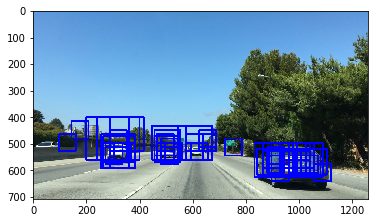

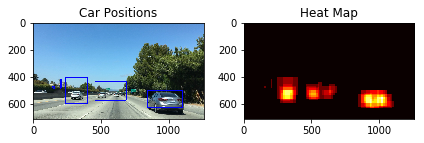

boxes found =  32


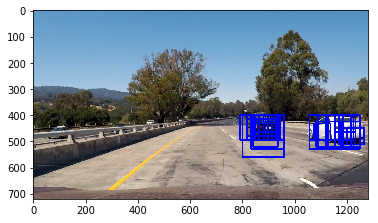

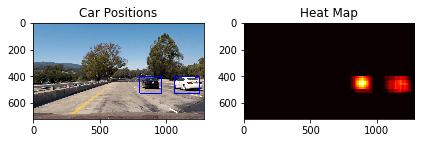

boxes found =  0


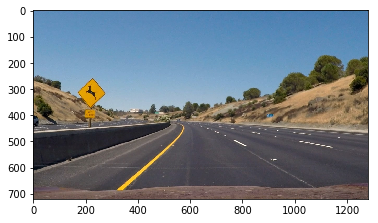

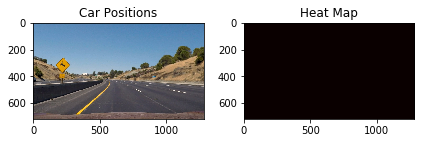

boxes found =  3


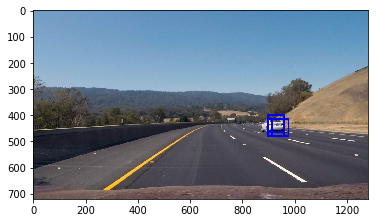

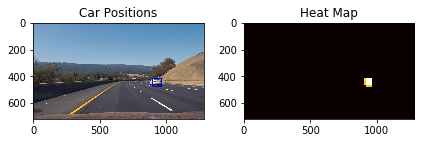

boxes found =  33


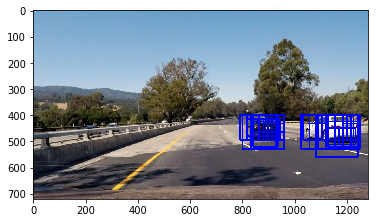

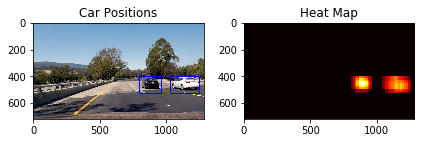

boxes found =  21


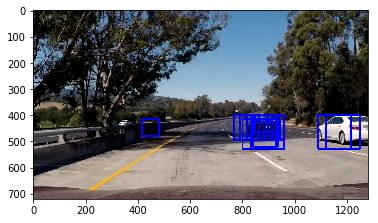

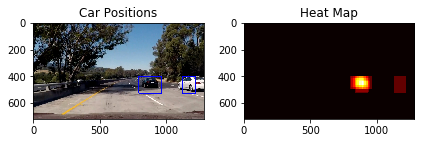

boxes found =  37


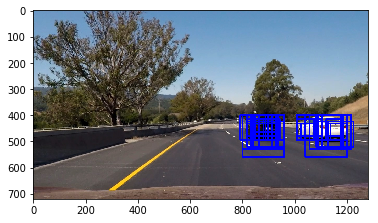

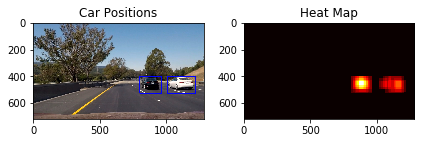

In [60]:
test_images = glob.glob('test_images\\*.jpg')
for img in test_images:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_img, heatmap = detection_pipeline(img)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite("marked_img.jpg",draw_img)